# Neural Networks
We tried to fit a neural network to the scaled (0, 1) data, taking all the predictors (non-zero variance) as input.

After testing a few architectures for the network, we saw that the MSE was rather variable, mostly when changing training/test data, and in a lesser measure when leaving randomness only to the validation split taken for early stopping (no good model could be generated without regularization). To tune hyperparameters, we performed cross-validation with different training/test sets, and a compromise between lower mean MSE and lower variance was made. We also observed the behavior of the predictions on a same training set, but with different validation splits.

In [59]:
library(keras)
use_condaenv("r-tensorflow")
use_session_with_seed(1)

data <- read.csv(file.path("..", "data", "training_data.csv"))
data <- na.omit(data)
data$PL <- data$VALENCE.PLEASANTNESS
data$VALENCE.PLEASANTNESS <- NULL
data$SWEETORSOUR <- NULL
data$Intensity <- as.numeric(data$Intensity)

Set session seed to 1 (disabled GPU, CPU parallelism)



In [60]:
cols = names(data[, sapply(data, function(v) var(v) != 0)])
data <- data[,cols]
dim(data)

[1]  708 3029

In [61]:
#training and test response sets

idx <- sample(nrow(data), 4*nrow(data)/5)
data_PL <- data$PL #used later
train.y <- data$PL[idx]
test.y <- data$PL[-idx]

#scaling
data$PL <- NULL
data <- as.matrix(data)

for (i in 1:ncol(data)){
    max <- max(data[,i])
    min <- min(data[,i])
    if (max != 1 & min != 0){
        for (j in 1:nrow(data)) data[j,i] <- (data[j,i]-min) / (max-min)
    }
}

#training and test scaled predictors sets
train.x <- data[idx,]
test.x <- data[-idx,]

The testing of multiple networks (layers, neurons) was easier using functions (with small variants of what is shown here). Below are the results of our best NN-models on a random split training/test set:

In [62]:
#create NN  with 1 layer
NN_one_predict <- function(N1){
     
    nn <- keras_model_sequential() %>%
      layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
      layer_dense(units = 1, activation = 'linear')
    
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 350, # stochastic gradient descent batch size
            epochs = 650,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        c(MSE, y.pred)
}

#create NN  with 2 layers
NN_two_predict <- function(N1, N2){
     
    nn <- keras_model_sequential() %>%
      layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
      layer_dense(units = N2, activation = 'relu',) %>%
      layer_dense(units = 1, activation = 'linear')
    
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 350, # stochastic gradient descent batch size
            epochs = 650,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        c(MSE, y.pred)
}

### 1 layer

In [63]:
res.one <- NN_one_predict(400) 
MSE <- res.one[1]
y.pred.one <- res.one[2:length(res.one)]
paste('MSE = ', MSE)

[1] "MSE =  433.047664136489"

The MSE is sligthly better than lasso regression on this split, but still leaves heavy unprecisions as illustrated in the graph below:

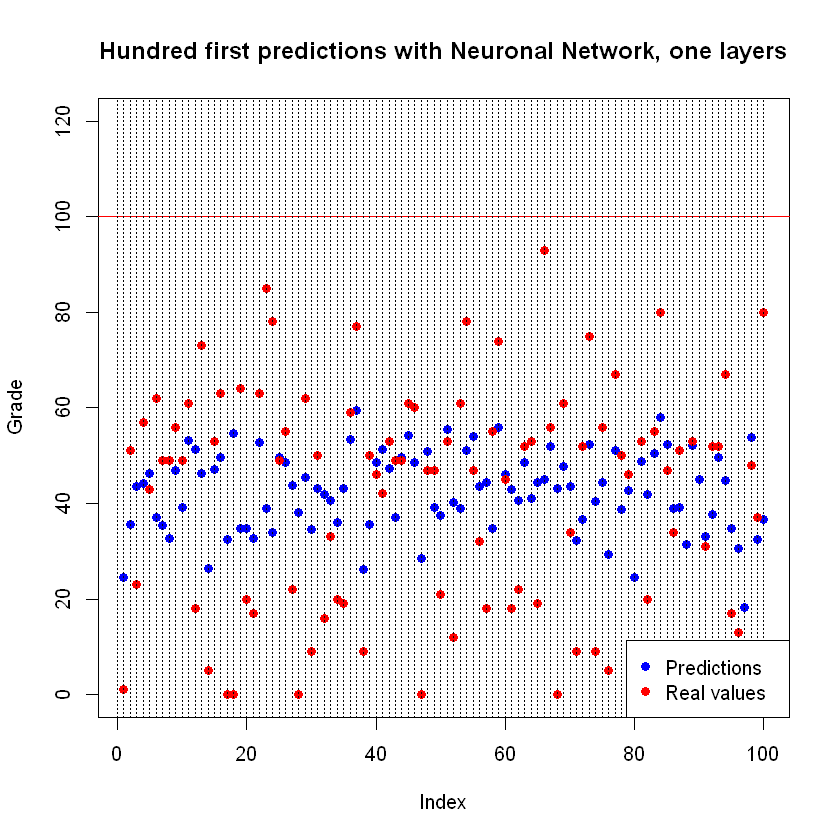

In [64]:
n = 100
plot(y.pred.one[1:n], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:n], col = 'red', pch = 19)
title('Hundred first predictions with Neuronal Network, one layers')
abline(h = 100, col = 'red')
for(i in seq(0, n, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

Compared to linear regression, the predictions are still rather contrained around the mean despite a lower MSE.

### 2 layers

In [65]:
res.two <- NN_two_predict(600, 100) 
MSE <- res.two[1]
y.pred.two <- res.two[2:length(res.two)]
paste('MSE = ', MSE)

[1] "MSE =  415.929074164879"

As for one 1-layer-NN, the MSE is sligthly better than lasso regression on this split, but still leaves heavy unprecisions as illustrated in the graph below:

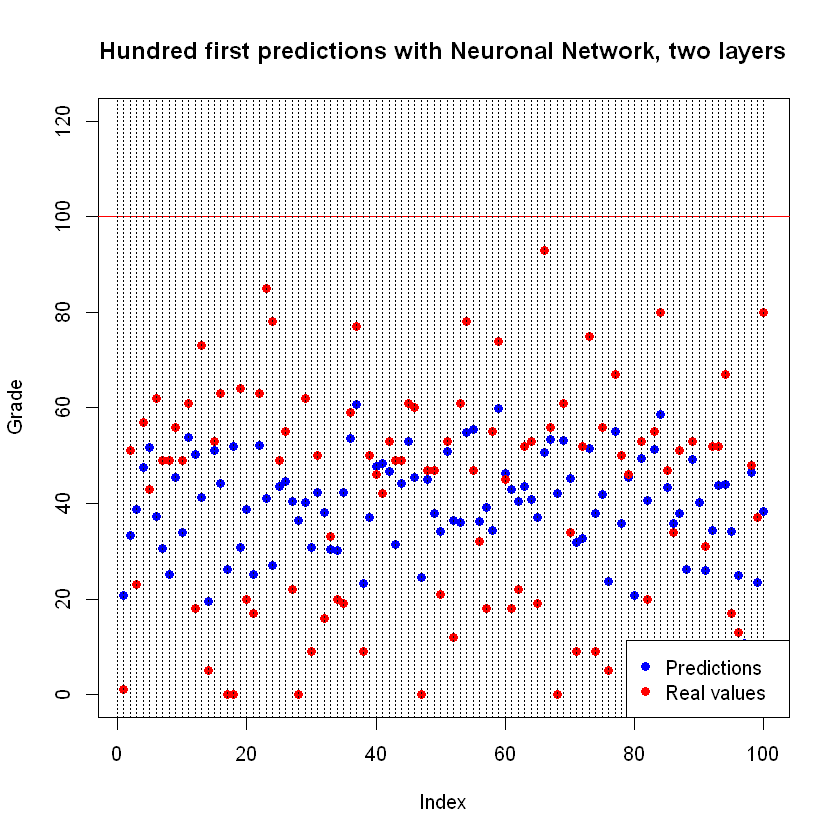

In [66]:
n = 100
plot(y.pred.two[1:n], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:n], col = 'red', pch = 19)
title('Hundred first predictions with Neuronal Network, two layers')
abline(h = 100, col = 'red')
for(i in seq(0, n, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

The best improvement compared to linear regression and our one layer-NN is that the predicted responses are much more spread away from the mean.

# MODEL JUSTIFICATION
We applied cross-validation to show the mean MSE and variance of the parameters combinations, elements that are taken into account for the choice of the model.
We also demonstrate that the variability of the MSE given different validation sets taken in the same training/set is not significant for choosing the model.

## 6-fold Cross-Validation without early-stopping

In [67]:
MSEs <- c()

for (N1 in c(1000, 600, 300)){
    for (N2 in c(600, 300, 100)){
        res <- c()
        #create architecture
        nn <- keras_model_sequential() %>%
            layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
            layer_dense(units = N2, activation = 'relu',) %>%
            layer_dense(units = 1, activation = 'linear')
        
    for (i in 0:5){
        
        idx <- (1+i*118):((i+1)*118)
        train.y <- data_PL[idx]
        test.y <- data_PL[-idx]
        train.x <- data[idx,]
        test.x <- data[-idx,]
        
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 120, # stochastic gradient descent batch size
            epochs = 300,
        )
        #compute MSE
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        res <- c(res, MSE)
        }
    #store cross-validated MSEs for each parameter combination
    MSEs <- rbind(MSEs, res)
    }
}

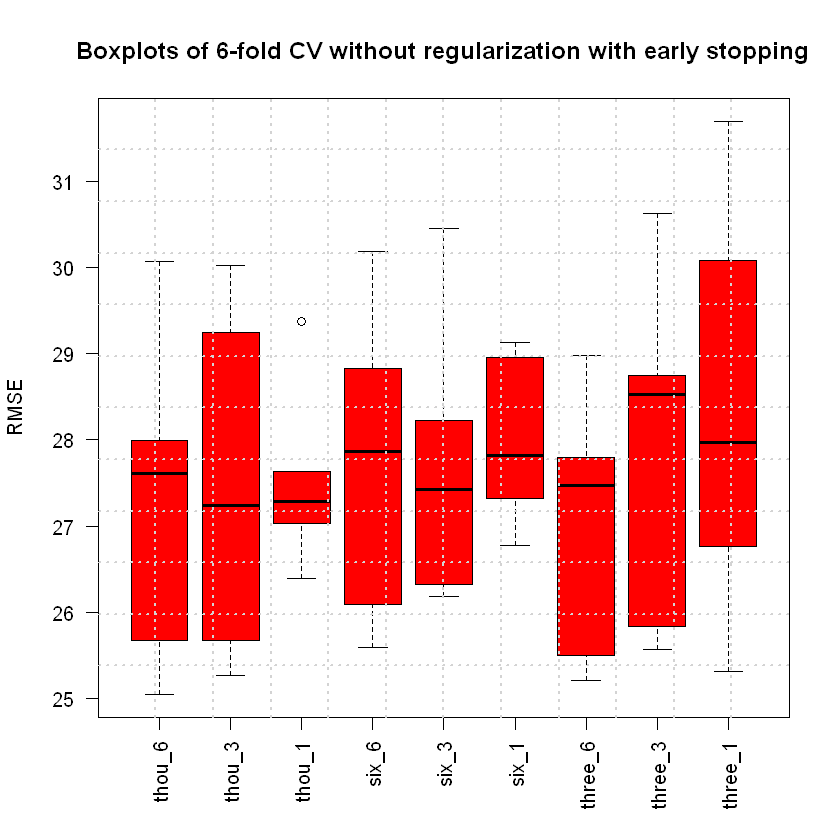

In [68]:
RMSEs <- MSEs**0.5
to_plot <- data.frame(thou_6 = RMSEs[1,], thou_3 = RMSEs[2,], thou_1 = RMSEs[3,],
                     six_6 = RMSEs[4,], six_3 = RMSEs[5,], six_1 = RMSEs[6,],
                     three_6 = RMSEs[7,], three_3 = RMSEs[8,], three_1 = RMSEs[9,])
boxplot(to_plot, ylab = "RMSE",  col = 'red', las = 2)
title('Boxplots of 6-fold CV without regularization with early stopping')
grid(12, lw = 2)

We can see that all MSE are terrible and highly variable after 300 epochs, and that no regularization ends quickly in overfitting, which justify the need for a validation split to use early stopping, and then to test the model on new test data to evaluate its performance. This results also stands for only one layer.

## Cross-Validation with early-stopping, 1 hidden layer

In [69]:
MSEs <- c()

for (N1 in c(1000, 800, 600, 400, 300, 200)){
    
    res <- c()
    #create architecture
    nn <- keras_model_sequential() %>%
        layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
        layer_dense(units = 1, activation = 'linear')
        
    for (i in 1:20){
        set.seed(i)
        #create different sets each turn
        idx <- sample(nrow(data), 4*nrow(data)/5)
        train.y <- data_PL[idx]
        test.y <- data_PL[-idx]
        train.x <- data[idx,]
        test.x <- data[-idx,]
        
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 250, # stochastic gradient descent batch size
            epochs = 300,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        #compute MSE
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        res <- c(res, MSE)
        }
    #store cross-validated MSEs for each parameter combination
    MSEs <- rbind(MSEs, res)
}

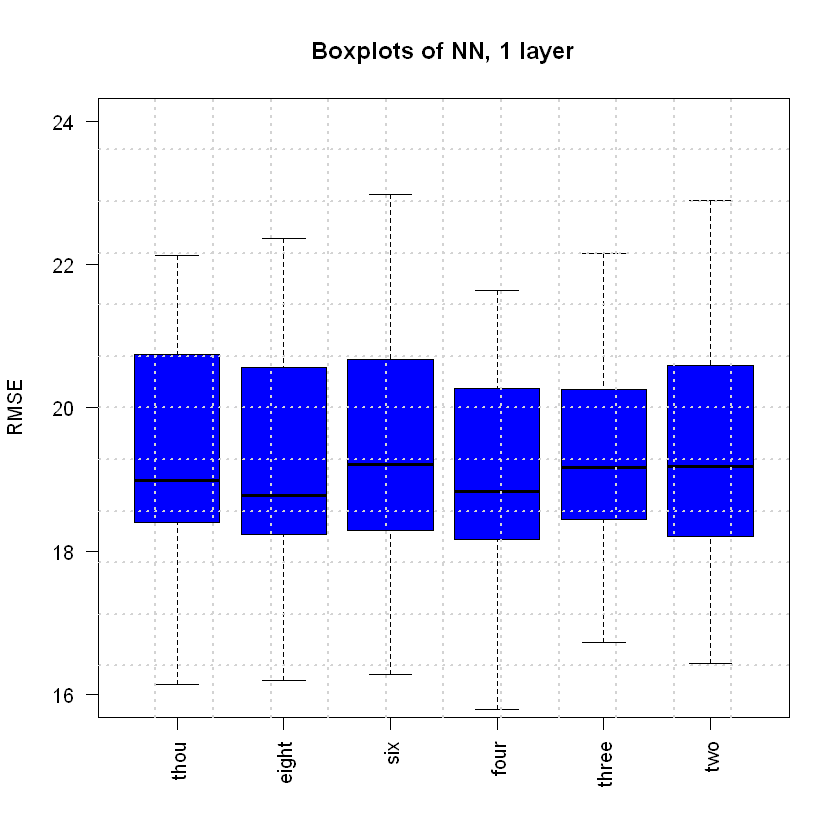

In [70]:
RMSEs <- MSEs**0.5
to_plot <- data.frame(thou = RMSEs[1,], eight = RMSEs[2,], six = RMSEs[3,],
                     four = RMSEs[4,], three = RMSEs[5,], two = RMSEs[6,])
boxplot(to_plot, ylab = "RMSE",  col = 'blue', ylim = c(16, 24), las = 2)
title('Boxplots of NN, 1 layer')
grid(12, lw = 2)

The first thing we observe configurations benefit from regularization. The best one-layer conformation seem to be 400 hundred neurons, but the difference with the others is not so sharp. 

## Cross-Validation with early-stopping, 2 hidden layers

In [71]:
MSEs <- c()

for (N1 in c(1000, 600, 300)){
    for (N2 in c(600, 300, 100)){
        res <- c()
        #create architecture
        nn <- keras_model_sequential() %>%
            layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
            layer_dense(units = N2, activation = 'relu',) %>%
            layer_dense(units = 1, activation = 'linear')
        
    for (i in 1:20){
        set.seed(i)
        #create different sets each turn
        idx <- sample(nrow(data), 4*nrow(data)/5)
        train.y <- data_PL[idx]
        test.y <- data_PL[-idx]
        train.x <- data[idx,]
        test.x <- data[-idx,]
        
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 250, # stochastic gradient descent batch size
            epochs = 300,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        #compute MSE
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        res <- c(res, MSE)
        }
    #store cross-validated MSEs for each parameter combination
    MSEs <- rbind(MSEs, res)
    }
}

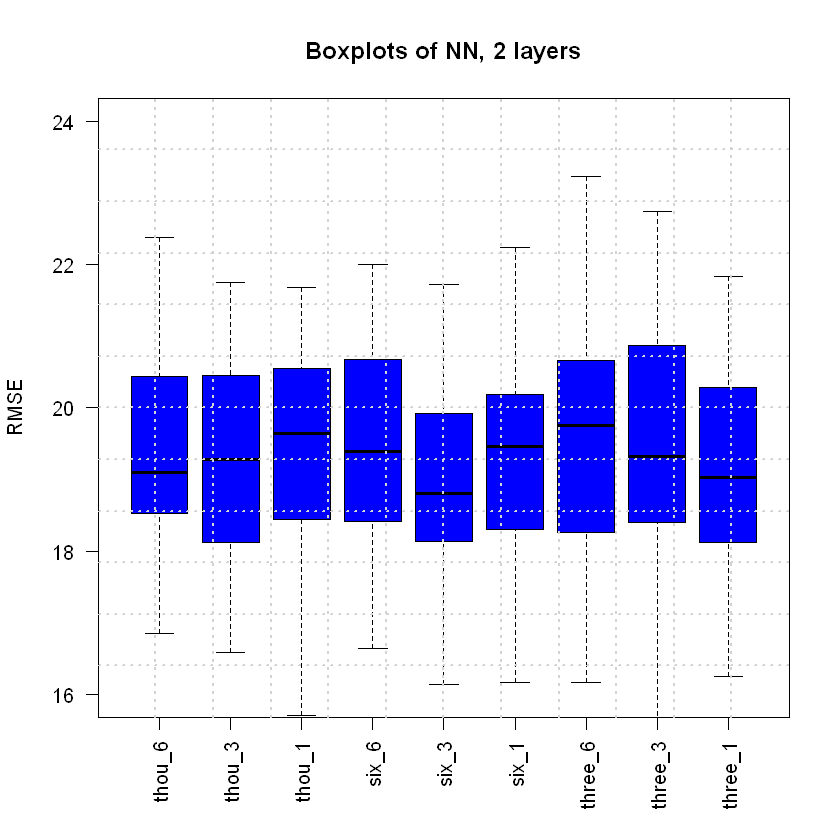

In [72]:
RMSEs <- MSEs**0.5
to_plot <- data.frame(thou_6 = RMSEs[1,], thou_3 = RMSEs[2,], thou_1 = RMSEs[3,],
                     six_6 = RMSEs[4,], six_3 = RMSEs[5,], six_1 = RMSEs[6,],
                     three_6 = RMSEs[7,], three_3 = RMSEs[8,], three_1 = RMSEs[9,])
boxplot(to_plot, ylab = "RMSE",  col = 'blue', ylim = c(16, 24), las = 2)
title('Boxplots of NN, 2 layers')
grid(12, lw = 2)

We observe that most configurations have comparable variance and that the cross-validation is not very conclusive, but over multiple trials we observed a slightly better score for the following configurations: 1000/600, 600/100, 600/300, 300/100. As their RMSEs are very similar, we chose 600/100 for its more stably good performance on repeated cross-validation. The results are neither worse or better than with a single layer.

## Validation split variance

In [73]:
each_result <- c()
mean_MSE <- c()

for (N1 in c(1000, 600, 300)){
     for (N2 in c(600, 300, 100)){
         all.MSE <- c()
         for (i in 1:10){
            res_ <- NN_two_predict(N1, N2)
            MSE <- res_[1]
            each_result <- rbind(each_result, c(N1, N2, MSE))
            all.MSE <- c(all.MSE, MSE)
        }
        mean_MSE <- rbind(mean_MSE, c(N1, N2, mean(all.MSE)))
    }
}

In [74]:
each_result <- data.frame(N1 = each_result[,1], N2 = each_result[,2], MSE = each_result[,3])
mean_MSE <- data.frame(N1 = mean_MSE[,1], N2 = mean_MSE[,2], MSE = mean_MSE[,3])

In [75]:
print("Individual results on each trial given particular parameters")
print(each_result)

[1] "Individual results on each trial given particular parameters"
     N1  N2      MSE
1  1000 600 525.1636
2  1000 600 516.6231
3  1000 600 546.0629
4  1000 600 547.4950
5  1000 600 516.1470
6  1000 600 517.7516
7  1000 600 533.1762
8  1000 600 526.1455
9  1000 600 536.2723
10 1000 600 553.0643
11 1000 300 519.2429
12 1000 300 524.8473
13 1000 300 531.3997
14 1000 300 503.6738
15 1000 300 534.6454
16 1000 300 534.2860
17 1000 300 543.4577
18 1000 300 512.0656
19 1000 300 540.6006
20 1000 300 534.9974
21 1000 100 504.1861
22 1000 100 533.1570
23 1000 100 530.9940
24 1000 100 495.8332
25 1000 100 502.7871
26 1000 100 527.4587
27 1000 100 535.4761
28 1000 100 541.9103
29 1000 100 532.5662
30 1000 100 521.0753
31  600 600 521.1189
32  600 600 499.8277
33  600 600 502.8821
34  600 600 558.2315
35  600 600 530.5894
36  600 600 501.0002
37  600 600 502.3748
38  600 600 516.9139
39  600 600 524.2314
40  600 600 526.3322
41  600 300 550.9348
42  600 300 532.7228
43  600 300 534.4870
44  600 3

We can observe that the MSE varies a bit given the validation set for each hyperparameter combination.

[1] "Mean MSE for each configuration"
    N1  N2      MSE
1 1000 600 531.7901
2 1000 300 527.9217
3 1000 100 522.5444
4  600 600 518.3502
5  600 300 524.5668
6  600 100 524.9051
7  300 600 528.5739
8  300 300 533.3579
9  300 100 530.1345


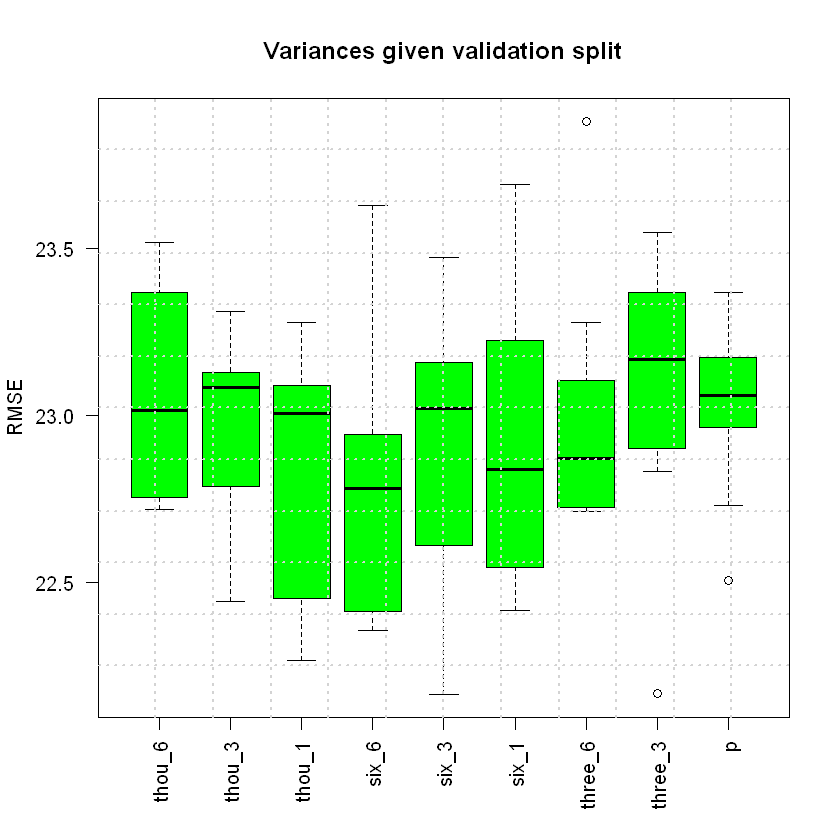

In [76]:
print("Mean MSE for each configuration")
print(mean_MSE)
p <- each_result$MSE**0.5
vars <- data.frame(thou_6 = p[1:10], thou_3 = p[11:20], thou_1 = p[21:30],
                     six_6 = p[31:40], six_3 = p[41:50], six_1 = p[51:60],
                     three_6 = p[61:70], three_3 = p[71:80], p = p[81:90])
boxplot(vars, ylab = "RMSE",  col = 'green', las = 2)
title('Variances given validation split')
grid(12, lw = 2)

We observe that the variance due to the validation split (early stopping) is much smaller than the variance when cross-validating over different training sets, but might be high enough to bias model selection (as the cross-validation was not very conclusive), and play a role when evaluating on the final test set. 

It also illustrate that the methods can indeed give pretty bad results on particular splits (mean RMSE around 23).